<a href="https://colab.research.google.com/github/Koshman-Nikita/GoogleCloudTTS/blob/main/naiveb_classif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Імпорт необхідних бібліотек

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt


# Завантаження даних

In [28]:
# Завантаження даних з файлу CSV
file_path = '/mnt/data/GBP_USD Historical Data.csv'

def load_data(file_path):
    data = pd.read_csv(file_path, skiprows=1)  # Пропуск першого рядка з заголовком
    data.columns = ["Date", "Price", "Open", "High", "Low", "Vol.", "Change %"]  # Встановлення назв стовпців вручну
    return data

# Спроба завантажити дані
data = load_data(file_path)
print(data.head())  # Перевірка першого ряду даних
print(data.info())  # Перевірка загальної інформації про дані
print(data.describe())  # Статистична інформація про числові стовпці


         Date   Price    Open    High     Low  Vol. Change %
0  12/28/2023  1.2730  1.2797  1.2829  1.2711   NaN   -0.50%
1  12/27/2023  1.2794  1.2719  1.2804  1.2697   NaN    0.53%
2  12/26/2023  1.2726  1.2693  1.2732  1.2683   NaN    0.29%
3  12/25/2023  1.2689  1.2709  1.2728  1.2682   NaN   -0.09%
4  12/22/2023  1.2700  1.2687  1.2746  1.2672   NaN    0.09%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      519 non-null    object 
 1   Price     519 non-null    float64
 2   Open      519 non-null    float64
 3   High      519 non-null    float64
 4   Low       519 non-null    float64
 5   Vol.      0 non-null      float64
 6   Change %  519 non-null    object 
dtypes: float64(5), object(2)
memory usage: 28.5+ KB
None
            Price        Open        High         Low  Vol.
count  519.000000  519.000000  519.000000  519.000000   0.0
m

# Передобробка даних

In [29]:
# Перевірка наявності необхідних стовпців та їх типів
print(data.columns)
print(data.dtypes)

# Перетворення стовпця 'Change %' на рядковий формат (якщо це необхідно)
if data['Change %'].dtype != 'object':
    data['Change %'] = data['Change %'].astype(str)

# Перетворення стовпця 'Change %' на числовий формат для зручності обробки
data['Change %'] = data['Change %'].str.replace('%', '').astype(float)

# Видалення рядків, де стовпці 'Price' або 'Change %' містять null значення
data = data.dropna(subset=['Price', 'Change %'])

# Перевірка, чи є значення у стовпцях 'Price' і 'Change %'
if data.empty:
    print("Стовпці 'Price' або 'Change %' містять тільки null значення.")
else:
    # Використовуємо стовпець 'Price' як ознаку
    X = data[['Price']].values
    # Бінарна ціль: 0 - зниження, 1 - підвищення
    y = np.where(data['Change %'] < 0, 0, 1)

    # Перевірка, що X та y не порожні
    print(f"Розмірність X: {X.shape}")
    print(f"Розмірність y: {y.shape}")

    # Розбиття даних на навчальну та тестову вибірки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Розмірність X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Розмірність X_test: {X_test.shape}, y_test: {y_test.shape}")


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')
Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %     object
dtype: object
Розмірність X: (519, 1)
Розмірність y: (519,)
Розмірність X_train: (415, 1), y_train: (415,)
Розмірність X_test: (104, 1), y_test: (104,)


# Реалізація класифікатора наївного Байєса

In [30]:
class NaiveBayesClassifier:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}
        self.classes = None
        self.features = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.features = X.shape[1]
        for cls in self.classes:
            X_cls = X[y == cls]
            self.priors[cls] = X_cls.shape[0] / X.shape[0]
            self.likelihoods[cls] = {i: {} for i in range(self.features)}
            for i in range(self.features):
                feature_values = X_cls[:, i]
                self.likelihoods[cls][i]['mean'] = feature_values.mean()
                self.likelihoods[cls][i]['var'] = feature_values.var()

    def _calculate_likelihood(self, mean, var, x):
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent

    def _calculate_posterior(self, x):
        posteriors = {}
        for cls in self.classes:
            prior = np.log(self.priors[cls])
            likelihood = 0
            for i in range(self.features):
                mean = self.likelihoods[cls][i]['mean']
                var = self.likelihoods[cls][i]['var']
                likelihood += np.log(self._calculate_likelihood(mean, var, x[i]))
            posteriors[cls] = prior + likelihood
        return posteriors

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = self._calculate_posterior(x)
            y_pred.append(max(posteriors, key=posteriors.get))
        return np.array(y_pred)

# Навчання класифікатора наївного Байєса
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train, y_train)

# Прогнозування та оцінка
y_pred = nb_classifier.predict(X_test)


# Оцінка моделі

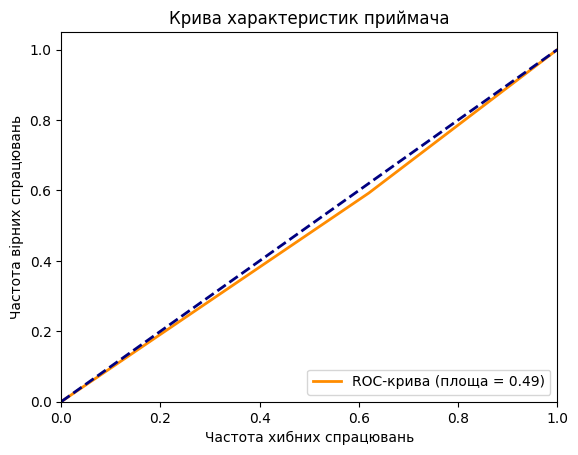

Точність: 0.49, AUC: 0.49


In [31]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC-крива (площа = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Частота хибних спрацювань')
    plt.ylabel('Частота вірних спрацювань')
    plt.title('Крива характеристик приймача')
    plt.legend(loc="lower right")
    plt.show()
    return accuracy, roc_auc

accuracy, roc_auc = evaluate_model(y_test, y_pred)
print(f'Точність: {accuracy:.2f}, AUC: {roc_auc:.2f}')


# Виконання регресії

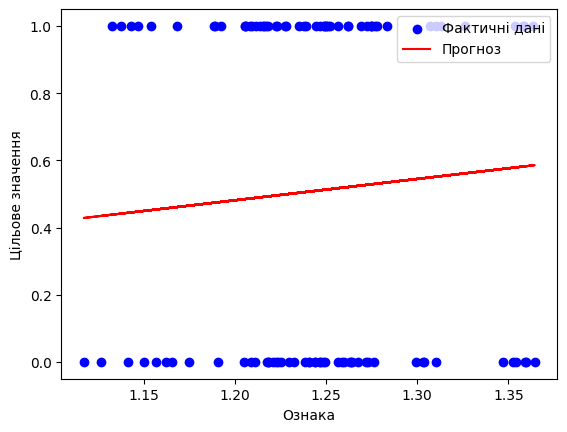

In [32]:
def linear_regression(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return theta_best

def predict_regression(X, theta):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return X_b.dot(theta)

# Підгонка моделі лінійної регресії
theta = linear_regression(X_train, y_train)

# Прогнозування за допомогою моделі регресії
y_pred_reg = predict_regression(X_test, theta)

# Візуалізація результатів регресії
plt.figure()
plt.scatter(X_test[:, 0], y_test, color='blue', label='Фактичні дані')
plt.plot(X_test[:, 0], y_pred_reg, color='red', label='Прогноз')
plt.xlabel('Ознака')
plt.ylabel('Цільове значення')
plt.legend()
plt.show()
